In [1]:
import logging
import ipywidgets as widgets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sompy
from sompy.decorators import timeit
from sompy.sompy import SOMFactory
logging.getLogger().setLevel(logging.WARNING)
import itertools
import functools
import datetime as dt

In [2]:
from tfprop_sompy.tfprop_vis import render_posmap_to_axes, kmeans_clust, ViewTFP

In [3]:
from IPython.display import display

In [4]:
logging.getLogger().setLevel(logging.WARNING)

Calc'd properties

Toughness

Thermal shock

Shape factor

Specific Stiffness

Specific Strength

Thermal distortion resistance

Elastic stored energy

Ductility index

In [5]:
# def properties_dataframe_from_file(path: str):
#     property_lists = TEM_SOM.parsing_refined_data(path)
#     frame = pd.DataFrame(index=property_lists[0], data={
#         'Youngs modulus': property_lists[1],
#         #'Specific stiffness': property_lists[2], # This property is calculated
#         'Yield strength': property_lists[3],
#         'Tensile strength': property_lists[4],
#         #'Specific strength': property_lists[5], # This property is calculated
#         'Elongation': property_lists[6],
#         'Compressive strength': property_lists[7],
#         'Flexural modulus': property_lists[8],
#         'Flexural strength': property_lists[9],
#         'Shear modulus': property_lists[10],
#         'Bulk modulus': property_lists[11],
#         'Poisson ratio': property_lists[12],
#         #'Shape factor': property_lists[13], # This property is calculated
#         'Hardness vickers': property_lists[14],
#         #'Elastic stored energy': property_lists[15], # This property is calculated
#         'Fatigue strength': property_lists[16],
#         'Fracture toughness': property_lists[17],
#         #'Toughness': property_lists[18], # This property is calculated
#         #'Ductility index': property_lists[19], # This property is calculated
#         'Melting point': property_lists[20],
#         'Max service temp': property_lists[21],
#         'Min service temp': property_lists[22],
#         'Thermal conductivity': property_lists[23],
#         'Specific heat capacity': property_lists[24],
#         'Thermal expansion coefficient': property_lists[25],
#         #'Thermal shock resistance': property_lists[26], # This property is calculated
#         #'Thermal distortion resistance': property_lists[27], # This property is calculated
#         'Latent heat of fusion': property_lists[28],
#         'Electrical resistivity': property_lists[29],
#         'Electrical conductivity': property_lists[30],
#         'Galvanic potential': property_lists[31],
#         'Mechanical loss coefficient': property_lists[32]
#     })
    
#     frame.columns = (*map(lambda x: x.replace(' ', '_'), frame.columns), )
    
#     frame.replace("Null", np.nan, inplace=True)
#     check_for_bad_properties(frame)
#     frame.dropna(inplace=True)
#     return frame

In [6]:
fin = 'MatPropClean1.csv'
# fin = 'data/fluid_data.csv'
# input_tfprop = ['Name', 'molecular weight', 'melting point', 'boiling point',
#                 'density', 'viscosity', 'heat capacity', 'vapor pressure',
#                 'surface tension', 'thermal conductivity']
# configuration_dictionary = {
#     "value_names": ['Name', 'molecular weight', 'melting point', 'boiling point',
#                 'density', 'viscosity', 'heat capacity', 'vapor pressure',
#                 'surface tension', 'thermal conductivity'],
#     "special_overrides": {
#         "viscosity": {
#             "scaling": "log"
#         }
#     }
    
# }
mapsize = (30, 30)
n_job = 1

#### find what parse_som is and what properties_dataframe_from_file is.. i think it's a command? it's parsing from the
#### data path
mats_data_df = pd.read_csv(fin)
##*##

In [7]:
#### determine som columns (aka mat property)
# som_columns = [*map(lambda a: a.replace(' ', '_'), (x for x in Parse_SOM.COLUMN_NAMES if x != "Material family"
#                      and x not in Parse_SOM.BAD_PROPERTIES))]

#### material data frame containts only above columns
# mats_data_df.columns = (*map(lambda x: x.replace(' ', '_'), mats_data_df.columns), )
##*##

In [8]:
# mats_data_df[som_columns].to_csv("proper_material_data.csv")

In [9]:
# Only drop NaN entries for the columns we're training on
# mats_data_df.dropna(subset=som_columns, inplace=True)

In [10]:

#### makes pandas dataframe?
mats_name_df = pd.DataFrame(mats_data_df.index)
km_cluster = 9
##*##

In [11]:

#### what does .assign do
# mats_data_df = mats_data_df.assign(bulk_over_young=lambda x: x.Bulk_modulus/x.Youngs_modulus,
#                    flexural_over_young=lambda x: x.Flexural_modulus/x.Youngs_modulus,
#                    shear_over_young=lambda x: x.Shear_modulus/x.Youngs_modulus)
##*##

In [12]:
# som_columns = [x for x in som_columns if not x in ["Bulk_modulus", "Flexural_modulus", "Shear_modulus"]] + ["bulk_over_young", "flexural_over_young", "shear_over_young"]

som_columns = [
    "Thickness",
    "Hardness_(GPa)",
    "Elastic_Modulus_(GPa)",
    "Hardness_Indentation_Depth_(nm)",
    "Modulus_Indentation_Depth_(nm)",
    "Poison_Ratio",
    #"Fused_Silica_Hardness_(GPa)",
    "Fused_Silica_Elastic_Modulus_(GPa)",
]

# mats_data_df = mats_data_df[som_columns]


In [13]:
descr = mats_data_df[som_columns].values

In [14]:

# # monkeypatch find_bmu to remove the process pool due to the costly overhead - gains ~4x training speed for this data set
# # maybe it works better for larger data sets?
# # probably want to look into using cython/openmp in sompy
# @timeit(logging.DEBUG)
# def find_bmu_monkeypatch(self, input_matrix, njb=1, nth=1):
#     from sompy.sompy import _chunk_based_bmu_find
#     """
#     Finds the best matching unit (bmu) for each input data from the input
#     matrix. It does all at once parallelizing the calculation instead of
#     going through each input and running it against the codebook.
#     :param input_matrix: numpy matrix representing inputs as rows and
#         features/dimension as cols
#     :param njb: number of jobs to parallelize the search
#     :returns: the best matching unit for each input
#     """
#     dlen = input_matrix.shape[0]
#     y2 = np.einsum('ij,ij->i', self.codebook.matrix, self.codebook.matrix)
#     chunk_bmu_finder = _chunk_based_bmu_find

#     def row_chunk(part):
#         return part * dlen // njb

#     def col_chunk(part):
#         return min((part+1)*dlen // njb, dlen)

#     chunks = [input_matrix[row_chunk(i):col_chunk(i)] for i in range(njb)]
#     b = map(lambda chk: chunk_bmu_finder(chk, self.codebook.matrix, y2, nth=nth), chunks)
#     bmu = np.asarray(list(itertools.chain(*b))).T
#     del b
    
#     # This part is unnecessary, it's just for visualizing as the structure changes
# #     orig_codebook_matrix = np.copy(sm.codebook.matrix)
#     cl_labels = kmeans_clust(sm, n_clusters=km_cluster)
#     ax.clear()
    
#     render_posmap_to_axes(ax, sm, mats_name_df, mats_data_df, km_cluster, cl_labels, show_data=True, labels=False)
#     with hm_output:
#         hm_output.clear_output()
#         heatmap_size = (20, 20)
#         heatmap_col_sz = 4
#         gauss_alpha = None
        
#         cmap = plt.get_cmap('RdYlBu_r')  # set color map
#         viewTFP = ViewTFP(*heatmap_size, '', stdev_colorscale_coeff=1., text_size=14)
#         viewTFP.show(sm, cl_labels, col_sz=heatmap_col_sz,
#                          which_dim='all', desnormalize=True, col_norm='mean',
#                          cmap=cmap, isOutHtmap=False)
        
# #     assert (orig_codebook_matrix == sm.codebook.matrix).all()
#     fig.canvas.draw()
#     return bmu
# sompy.sompy.SOM.find_bmu = find_bmu_monkeypatch

In [15]:
# monkeypatch _batchtrain so we can display what's going on
def _batchtrain_monkeypatch(self, trainlen, radiusin, radiusfin, njob=1,
                shared_memory=False):
    from time import time
    radius = np.linspace(radiusin, radiusfin, trainlen)

    if shared_memory:
        data = self._data
        data_folder = tempfile.mkdtemp()
        data_name = os.path.join(data_folder, 'data')
        dump(data, data_name)
        data = load(data_name, mmap_mode='r')

    else:
        data = self._data

    bmu = None

    # X2 is part of euclidean distance (x-y)^2 = x^2 +y^2 - 2xy that we use
    # for each data row in bmu finding.
    # Since it is a fixed value we can skip it during bmu finding for each
    # data point, but later we need it calculate quantification error
    fixed_euclidean_x2 = np.einsum('ij,ij->i', data, data)

    logging.info(" radius_ini: %f , radius_final: %f, trainlen: %d\n" %
                 (radiusin, radiusfin, trainlen))

    for i in range(trainlen):
        t1 = time()
        neighborhood = self.neighborhood.calculate(
            self._distance_matrix, radius[i], self.codebook.nnodes)
        bmu = self.find_bmu(data, njb=njob)
        self.codebook.matrix = self.update_codebook_voronoi(data, bmu,
                                                            neighborhood)

        #lbugnon: ojo! aca el bmy[1] a veces da negativo, y despues de eso se rompe...hay algo raro ahi
        qerror = (i + 1, round(time() - t1, 3),
                  np.mean(np.sqrt(bmu[1] + fixed_euclidean_x2))) #lbugnon: ojo aca me tiró un warning, revisar (commit sinc: 965666d3d4d93bcf48e8cef6ea2c41a018c1cb83 )
        #lbugnon
        #ipdb.set_trace()
        #
        logging.info(
            " epoch: %d ---> elapsed time:  %f, quantization error: %f\n" %
            qerror)
        
        # this is the reason why we override the function
        update_sm_info(*qerror)
        
        if np.any(np.isnan(qerror)):
            logging.info("nan quantization error, exit train\n")

            #sys.exit("quantization error=nan, exit train")

    bmu[1] = np.sqrt(bmu[1] + fixed_euclidean_x2)
    self._bmu = bmu
sompy.sompy.SOM._batchtrain = _batchtrain_monkeypatch

In [16]:
# from importlib import reload
# from sompy import sompy as smlib
# reload(smlib)
# from sompy.sompy import SOMFactory
# None
descr.shape

(424, 7)

In [17]:
sm = SOMFactory.build(descr, mapsize=mapsize, normalization='var', initialization='pca', component_names=som_columns)

<IPython.core.display.Javascript object>


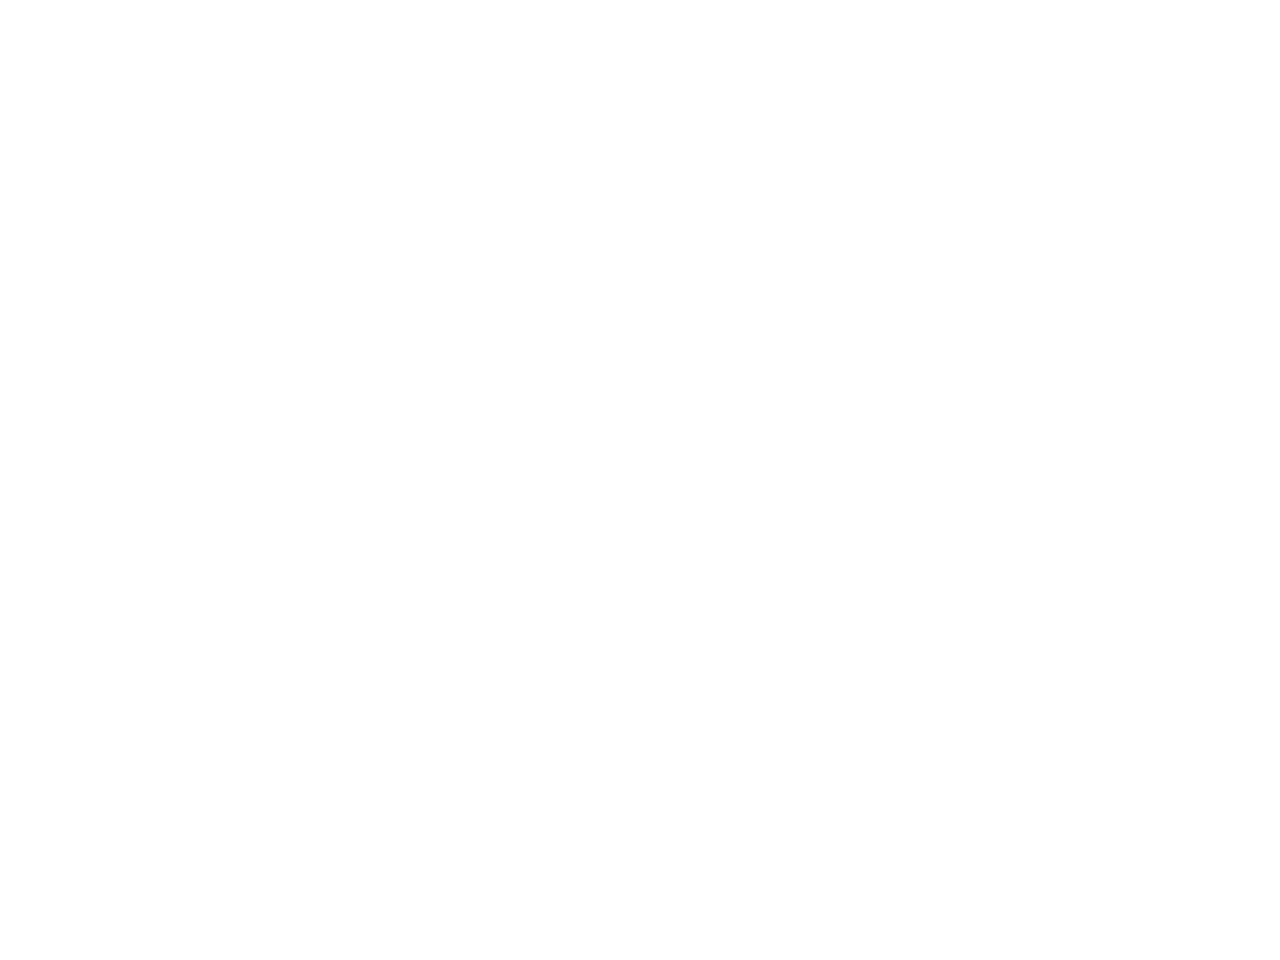

<IPython.core.display.Javascript object>


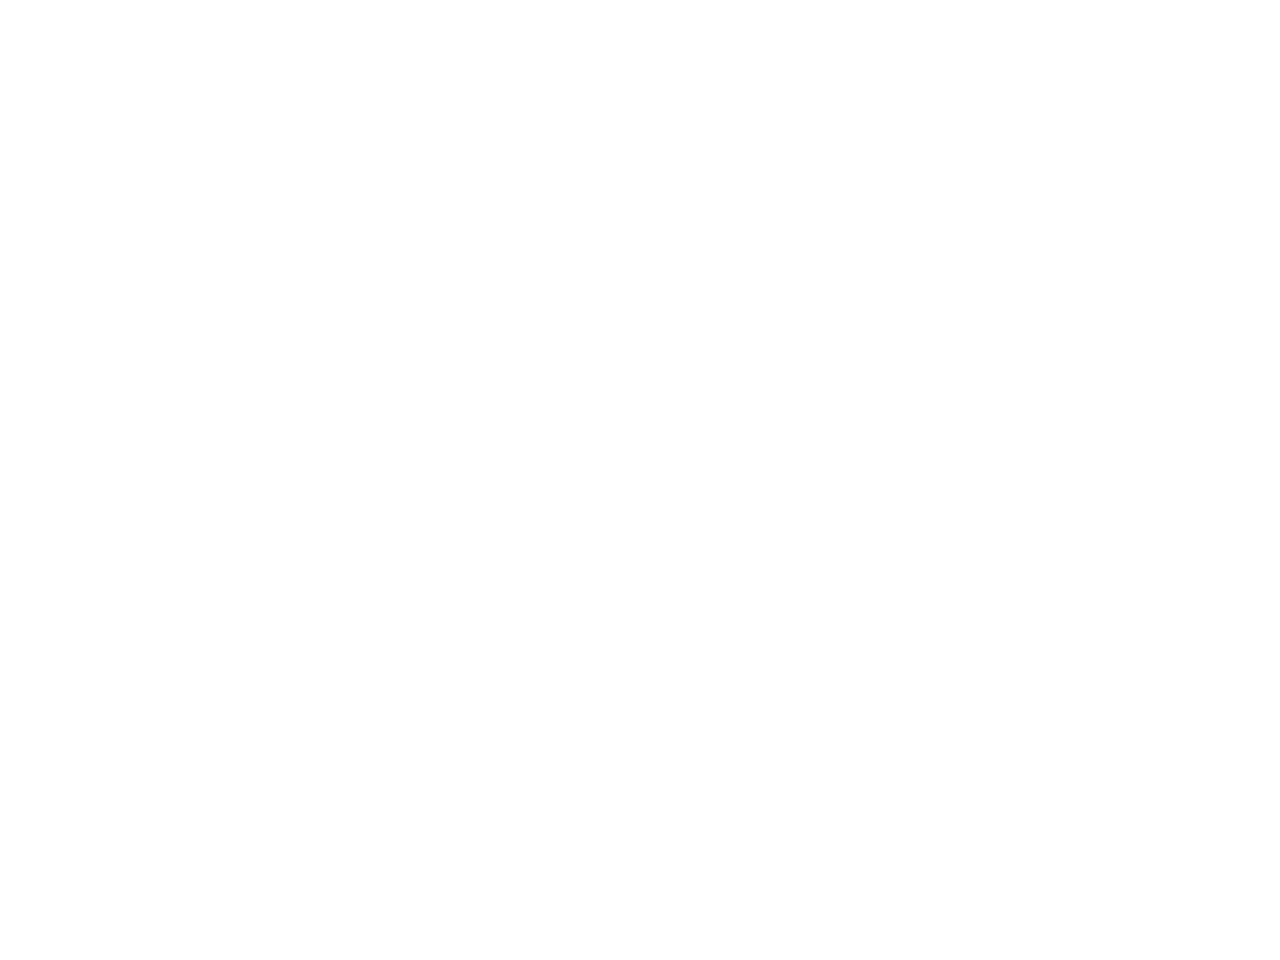

NumExpr defaulting to 4 threads.


In [18]:
%matplotlib notebook
# I'm pretty sure the sompy library's doing a lot of not-nice things to the
# global matplotlib state
b = widgets.Button(description="Train")
out = widgets.Output(layout={'border': '1px solid black'})
fig_cl, ax_cl = plt.subplots(1,1)
fig_hm, ax_hm = plt.subplots(1,1)
hm_output = widgets.Output()

def save_som_data(sm: sompy.sompy.SOM, name: str):
    # This will overwrite the old hd5 file, so be aware
    with pd.HDFStore(name, mode="w") as store:
        store['sm_codebook_matrix'] = pd.DataFrame(sm.codebook.matrix, columns=som_columns)
        store['sm_data'] = mats_data_df.drop("Row", axis='columns')
        store['sm_codebook_mapsize'] = pd.Series(mapsize)
        # FIXME: This does a direct access of the pandas dataframe internals
        # in order to directly write to the file
        # For some reason writing an object("string") series to the store
        # renders it unreadable
        columns_group = store._handle.create_group(store._handle.root, 'sm_codebook_columns')
        stored_columns_array = store._handle.create_array(columns_group, "property_names", list(som_columns), "Material property names")
        matfamilies_group = store._handle.create_group(store._handle.root, 'sm_codebook_matfamilies')
        stored_matfamilies_array = store._handle.create_array(matfamilies_group, "material_families", list(mats_data_df["Row"]), "Material families")
    with out:
        print(f"Saved to {name}")

def do_training(*args):
    out.clear_output()
    with out:
        sm.train(n_job=n_job, verbose='debug', train_rough_len=0,
                 train_finetune_len=0)

        topographic_error = sm.calculate_topographic_error()
        quantization_error = np.mean(sm._bmu[1])
        print("Topographic error = {:.5f}; Quantization error = {:.5f};"
              .format(topographic_error, quantization_error))
b.on_click(do_training)

epoch_text_widget = widgets.Label(value="Epoch: 0")
topo_err_text_widget = widgets.Label(value="Topographic error: 0")
quantization_err_text_widget = widgets.Label(value="Quantization error: 0")
infobox = widgets.VBox([epoch_text_widget, topo_err_text_widget, quantization_err_text_widget])

today = dt.date.today()
outname = widgets.Text(description="Output file", value=f"som_codemat_{len(som_columns)}props_{today.strftime('%y-%m-%d')}.h5")
savebtn = widgets.Button(description="Save")
savebox = widgets.VBox([outname, savebtn], layout={'border': '1px solid black'})

savebtn.on_click(lambda *args: save_som_data(sm, outname.value))

graph_display = widgets.Output()
with graph_display:
    display(fig_cl)
    display(hm_output)

def update_sm_info(epoch, topographic_err, quantization_err):
    epoch_text_widget.value = "Epoch: {}".format(epoch)
    topo_err_text_widget.value = "Topographic error: {}".format(topographic_err)
    quantization_err_text_widget.value = "Quantization error: {}".format(quantization_err)

widgets.VBox([graph_display, widgets.Box([widgets.VBox([savebox, b, infobox]), out])])

With viscosity log correction:
*    Topographic error: 0.028
*    Quantization error: 0.04490277296925648

Without viscosity log correction:
*    Topographic error: 0.051
*    Quantization error: 0.04426403053268633

Without log viscosity correction
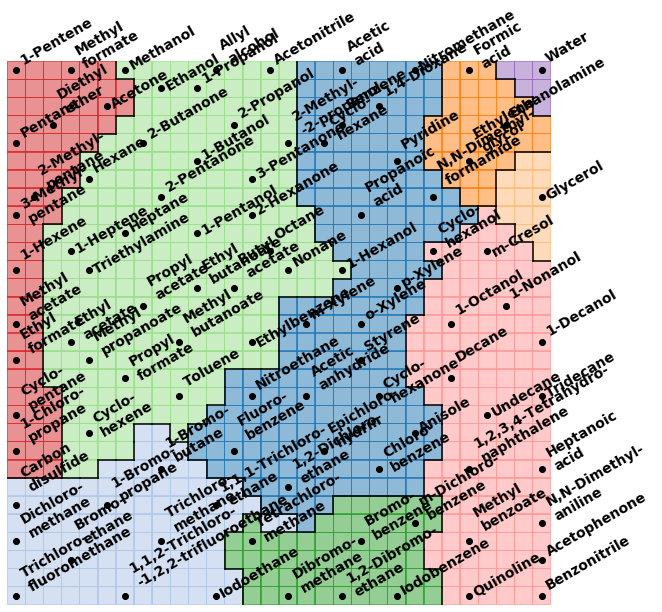

With viscosity log correction:
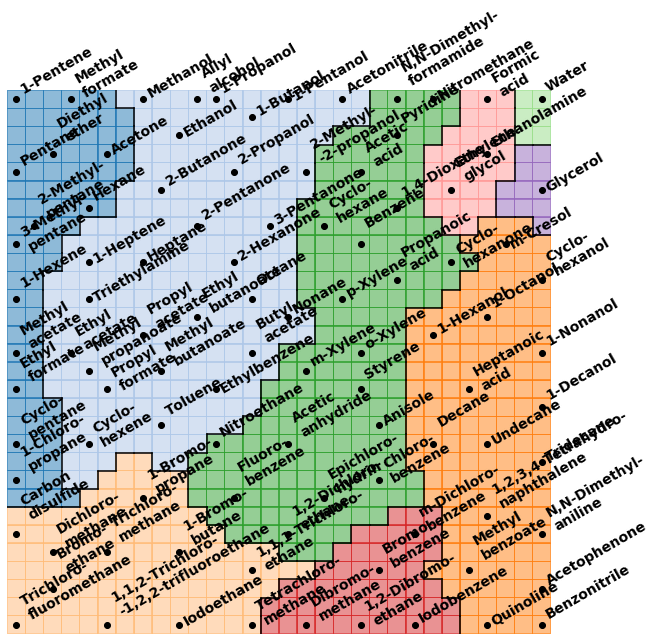

19-02-26
   
    Using SOM, we are able to identify and separate outlier properties in our dataset,

In [19]:
%matplotlib inline
from tfprop_sompy.tfprop_vis import show_posmap
logging.getLogger().setLevel(logging.WARNING)

def create_posmap(mysom: sompy.sompy.SOM, num_clusters: int=km_cluster):
    cl_labels = kmeans_clust(mysom, n_clusters=num_clusters)

    # plot positioning map with clustered groups
    show_posmap(mysom, mats_name_df, mats_name_df,
                km_cluster, cl_labels,
                show_data=False, labels=False)

In [20]:
%matplotlib inline
create_posmap(sm)

Performing K-means clustering to SOM trained data...


ValueError: Expected 2D array, got 1D array instead:
array=[30. 30.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
o = widgets.Output()
with o:
    for i in range(2, 20):
        create_posmap(sm, num_clusters=i)
o

In [ ]:
%matplotlib inline
from tfprop_sompy.tfprop_vis import ViewTFP
logging.getLogger().setLevel(logging.WARNING)
heatmap_size = (20, 20)
heatmap_col_sz = 4
gauss_alpha = None

viewTFP = ViewTFP(*heatmap_size, '', stdev_colorscale_coeff=1., text_size=14)

In [ ]:
my_out = widgets.Output()
cmap = plt.get_cmap('RdYlBu_r')  # set color map
cl_labels = kmeans_clust(sm, n_clusters=km_cluster)

# No scaling
viewTFP.knee_value = 0.0
with my_out:
    print("Linear scaling")
    viewTFP.show(sm, cl_labels, col_sz=heatmap_col_sz,
                         which_dim='all', desnormalize=True, col_norm='mean',
                         cmap=cmap)
my_out

In [ ]:
my_out = widgets.Output()
cmap = plt.get_cmap('RdYlBu_r')  # set color map
cl_labels = kmeans_clust(sm, n_clusters=km_cluster)

# No scaling
viewTFP.knee_value = 0.0
with my_out:
    print("Log scaling")
    viewTFP.show(sm, cl_labels, col_sz=heatmap_col_sz,
                         which_dim='all', desnormalize=True, col_norm='mean',
                         cmap=cmap, normalizer="log")
my_out

(19/02/22) 
Linear Scaling, Everet's 11-param dataset
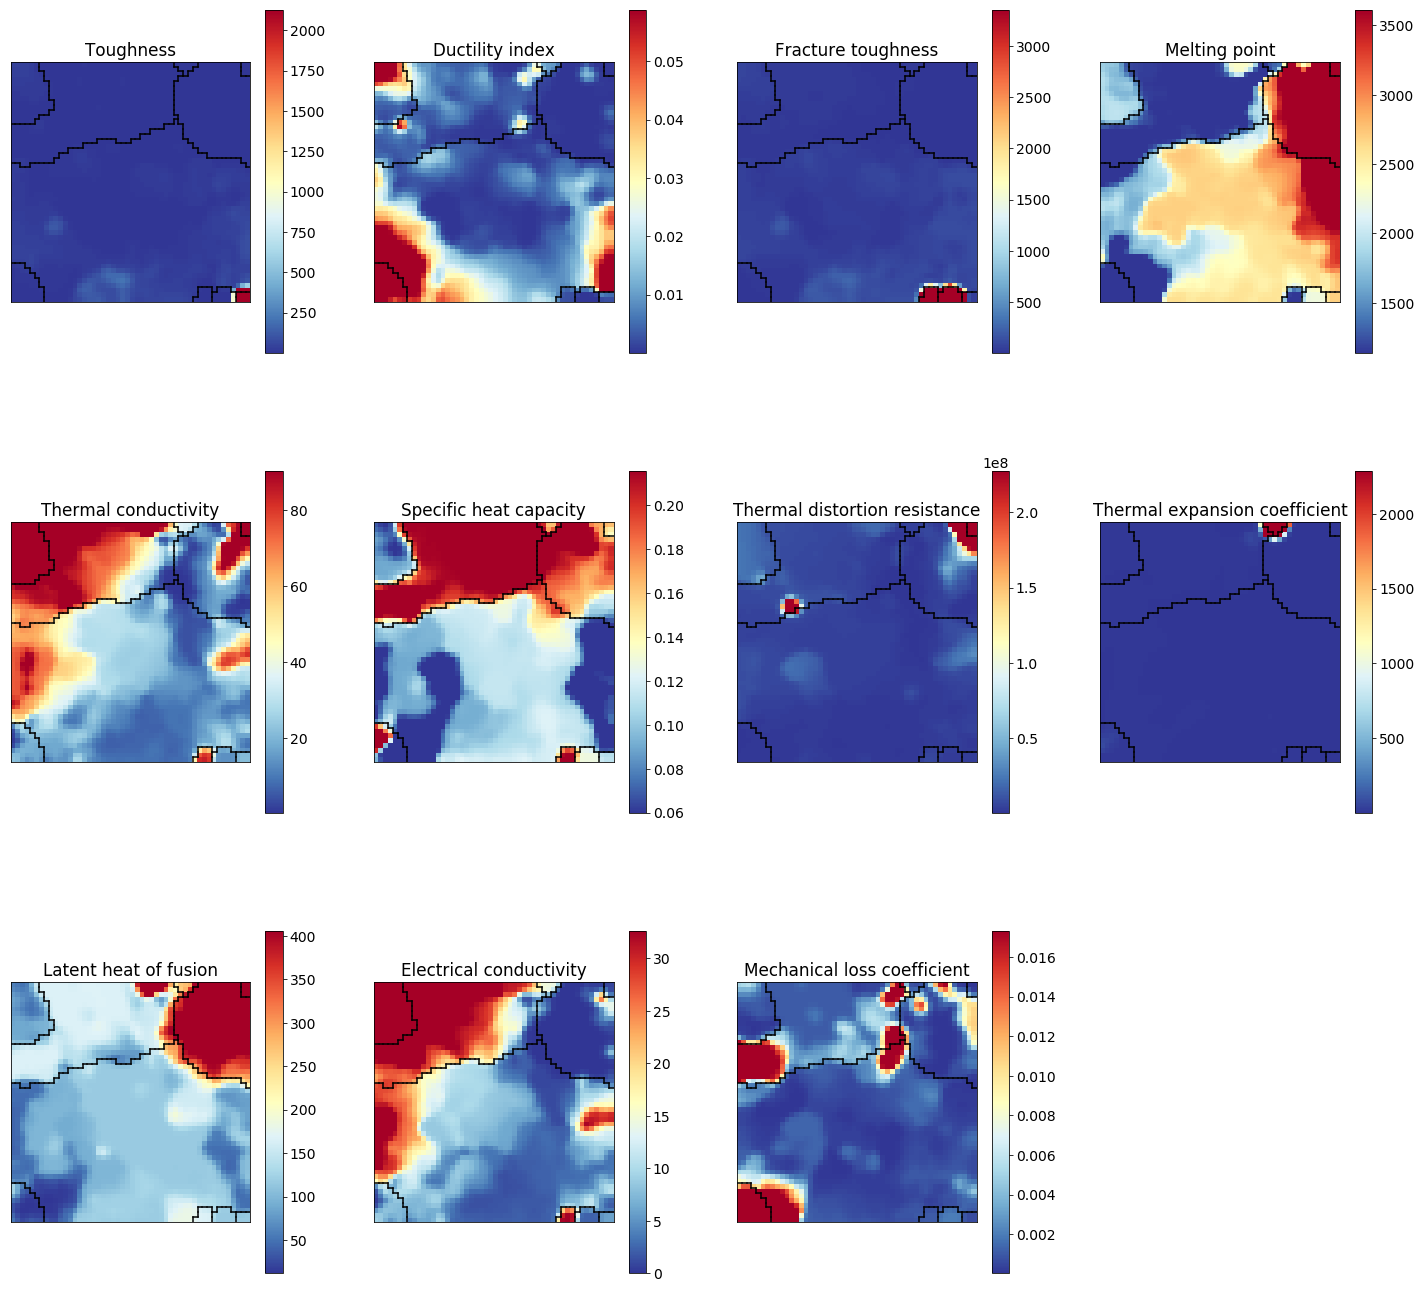

(19/02/22)
Log Scaling, Everet's 11-param dataset
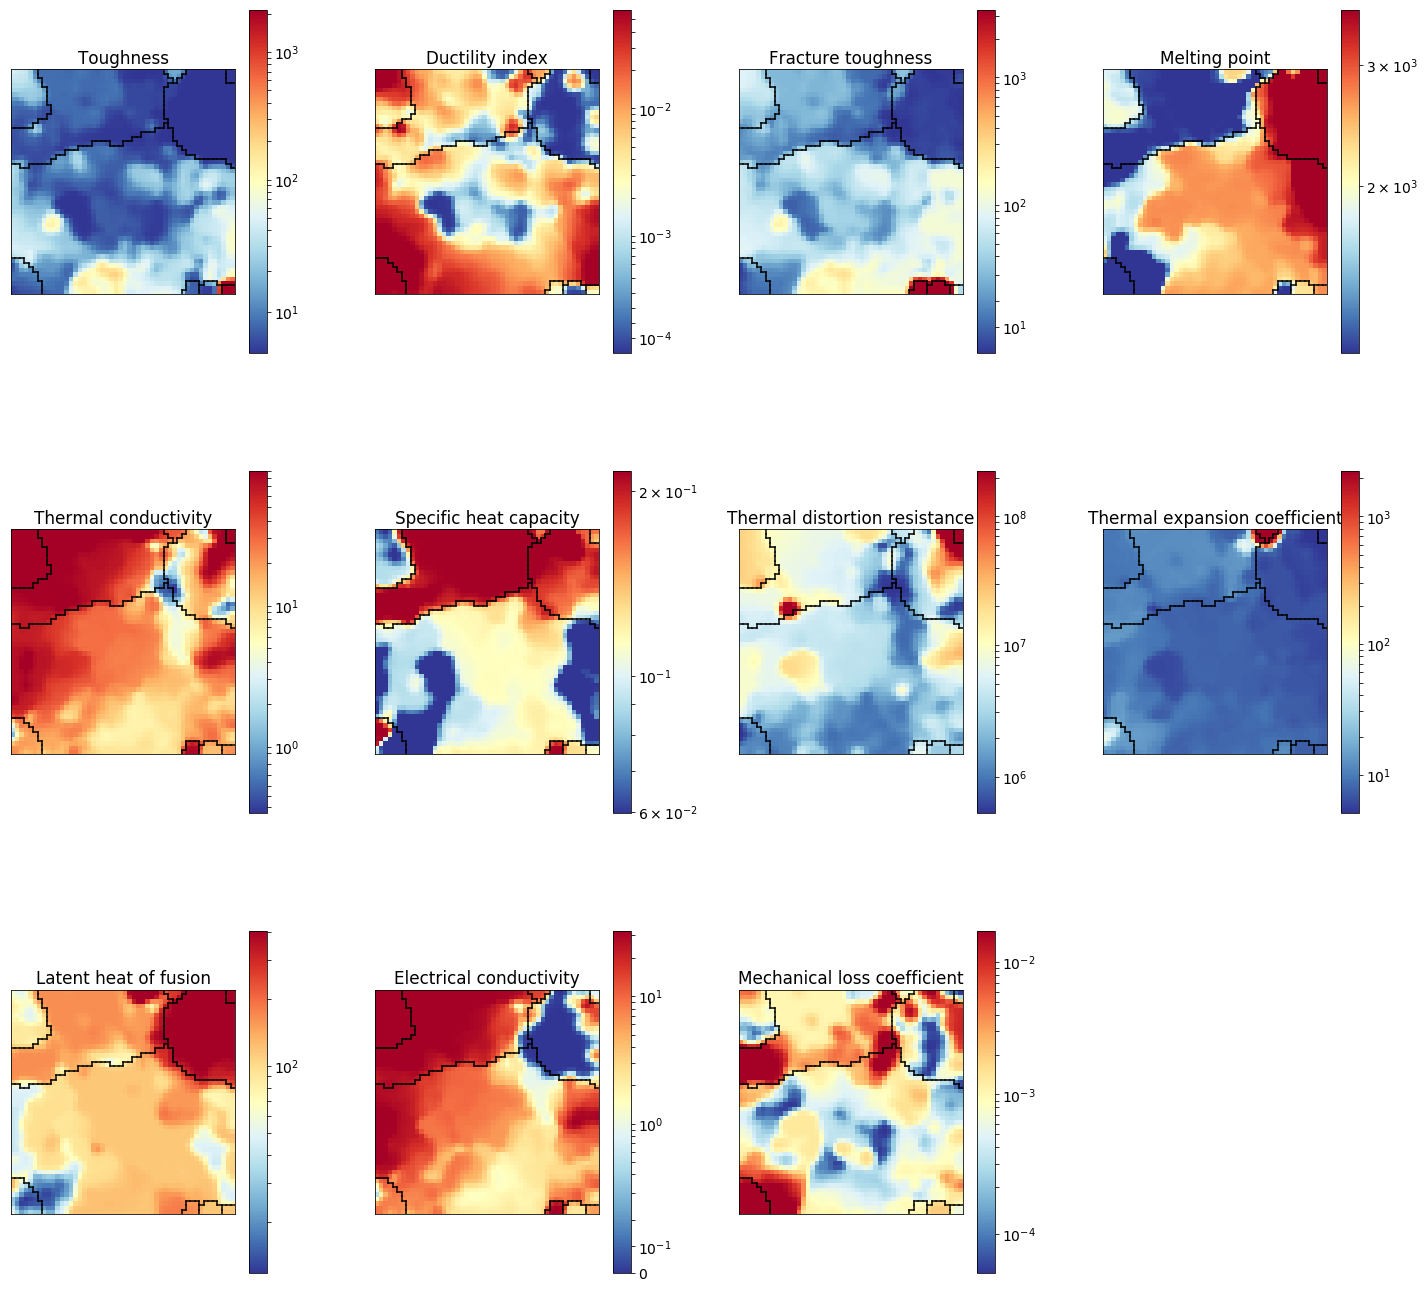

In [ ]:
sm.codebook.matrix.shape

In [ ]:
sm._data.shape

In [ ]:
sm._bmu